# Cargamos librerias

In [ ]:
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import time
import datetime

In [ ]:
# Paso 2: Cargar el dataset CIFAR10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Paso 3: Preprocesar los datos
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

170498071/170498071 [==============================] - 7s 0us/step


In [ ]:
print("Etiquetas de train (en vector):", y_train)

Etiquetas de train (en vector): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


#Obtenemos un array con todas las labels de CIFAR10

In [ ]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos. Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método .get_cmap() de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


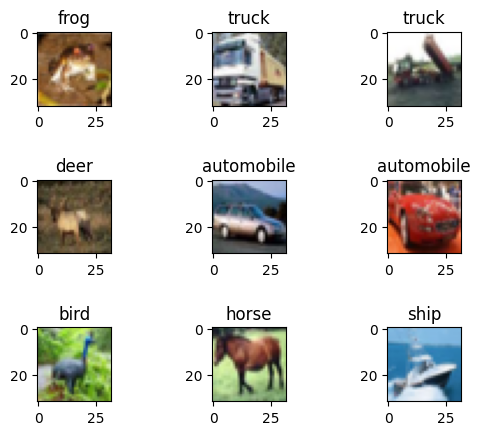

In [ ]:
# Pintemos una muestra de las las imagenes del dataset MNIST
import numpy as np
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    class_index = np.argmax(y_train[i])
    plt.title(cifar10_labels[class_index])

plt.subplots_adjust(hspace=1)
plt.show()



# Modelo

In [ ]:
from keras.layers import Dense, Dropout
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.summary()

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))  # Agregar dropout con una tasa de 0.3
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))  # Agregar dropout con una tasa de 0.3
model.add(Dense(128, activation='relu'))  # Agregar dos capas más
model.add(Dropout(0.3))  # Agregar dropout con una tasa de 0.3
model.add(Dense(10, activation='softmax'))


58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

 Descongelar las últimas capas del modelo base para fine-tuning

In [ ]:
for layer in model.layers[0].layers[:-4]:
    layer.trainable = False

In [ ]:
# agrgandao data ugmentaion

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,  # Rango de rotación en grados
    width_shift_range=0.1,  # Desplazamiento horizontal
    height_shift_range=0.1,  # Desplazamiento vertical
    horizontal_flip=True,  # Volteo horizontal
    zoom_range=0.1  # Rango de zoom
)

In [ ]:
datagen.fit(x_train)

. Optimizador, función error

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


Definir Early Stopping

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

Contador

In [ ]:
t = time.perf_counter()

entrenar modelo con early stopping

In [ ]:
batch_size = 512
epochs = 20

In [ ]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

Epoch 1/20
97/97 [==============================] - 55s 388ms/step - loss: 1.6402 - accuracy: 0.3988 - val_loss: 1.0864 - val_accuracy: 0.6251
Epoch 2/20
97/97 [==============================] - 34s 350ms/step - loss: 1.1484 - accuracy: 0.6110 - val_loss: 0.9863 - val_accuracy: 0.6627
Epoch 3/20
97/97 [==============================] - 34s 345ms/step - loss: 1.0201 - accuracy: 0.6583 - val_loss: 0.8468 - val_accuracy: 0.7114
Epoch 4/20
97/97 [==============================] - 33s 337ms/step - loss: 0.9571 - accuracy: 0.6774 - val_loss: 0.8709 - val_accuracy: 0.7039
Epoch 5/20
97/97 [==============================] - 34s 348ms/step - loss: 0.9142 - accuracy: 0.6918 - val_loss: 0.8207 - val_accuracy: 0.7174
Epoch 6/20
97/97 [==============================] - 33s 337ms/step - loss: 0.8809 - accuracy: 0.7025 - val_loss: 0.8475 - val_accuracy: 0.7083
Epoch 7/20
97/97 [==============================] - 35s 356ms/step - loss: 0.8484 - accuracy: 0.7141 - val_loss: 0.7484 - val_accuracy: 0.7421

In [ ]:
print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:09:14.045020


313/313 [==============================] - 3s 10ms/step - loss: 0.7328 - accuracy: 0.7531
Accuracy: 0.7530999779701233


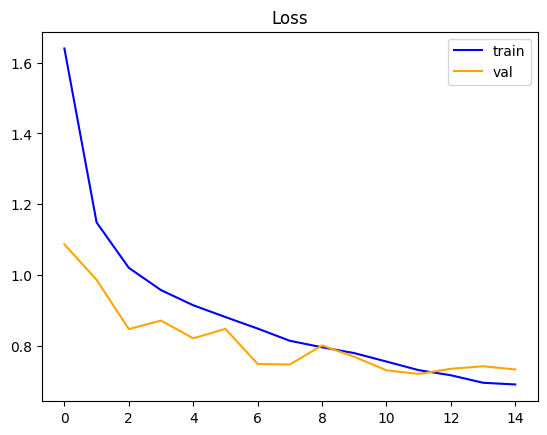

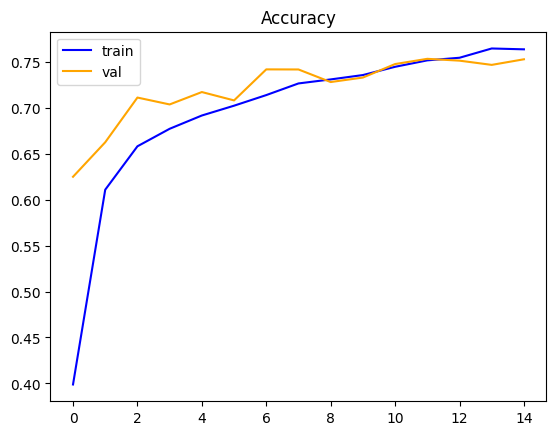

In [ ]:
# Evaluar el modelo
_, accuracy = model.evaluate(x_test, y_test)
print('Accuracy:', accuracy)

# Plot de la pérdida durante el entrenamiento
plt.title('Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

# Plot de la precisión durante el entrenamiento
plt.title('Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(x_test)

313/313 [==============================] - 2s 7ms/step


0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


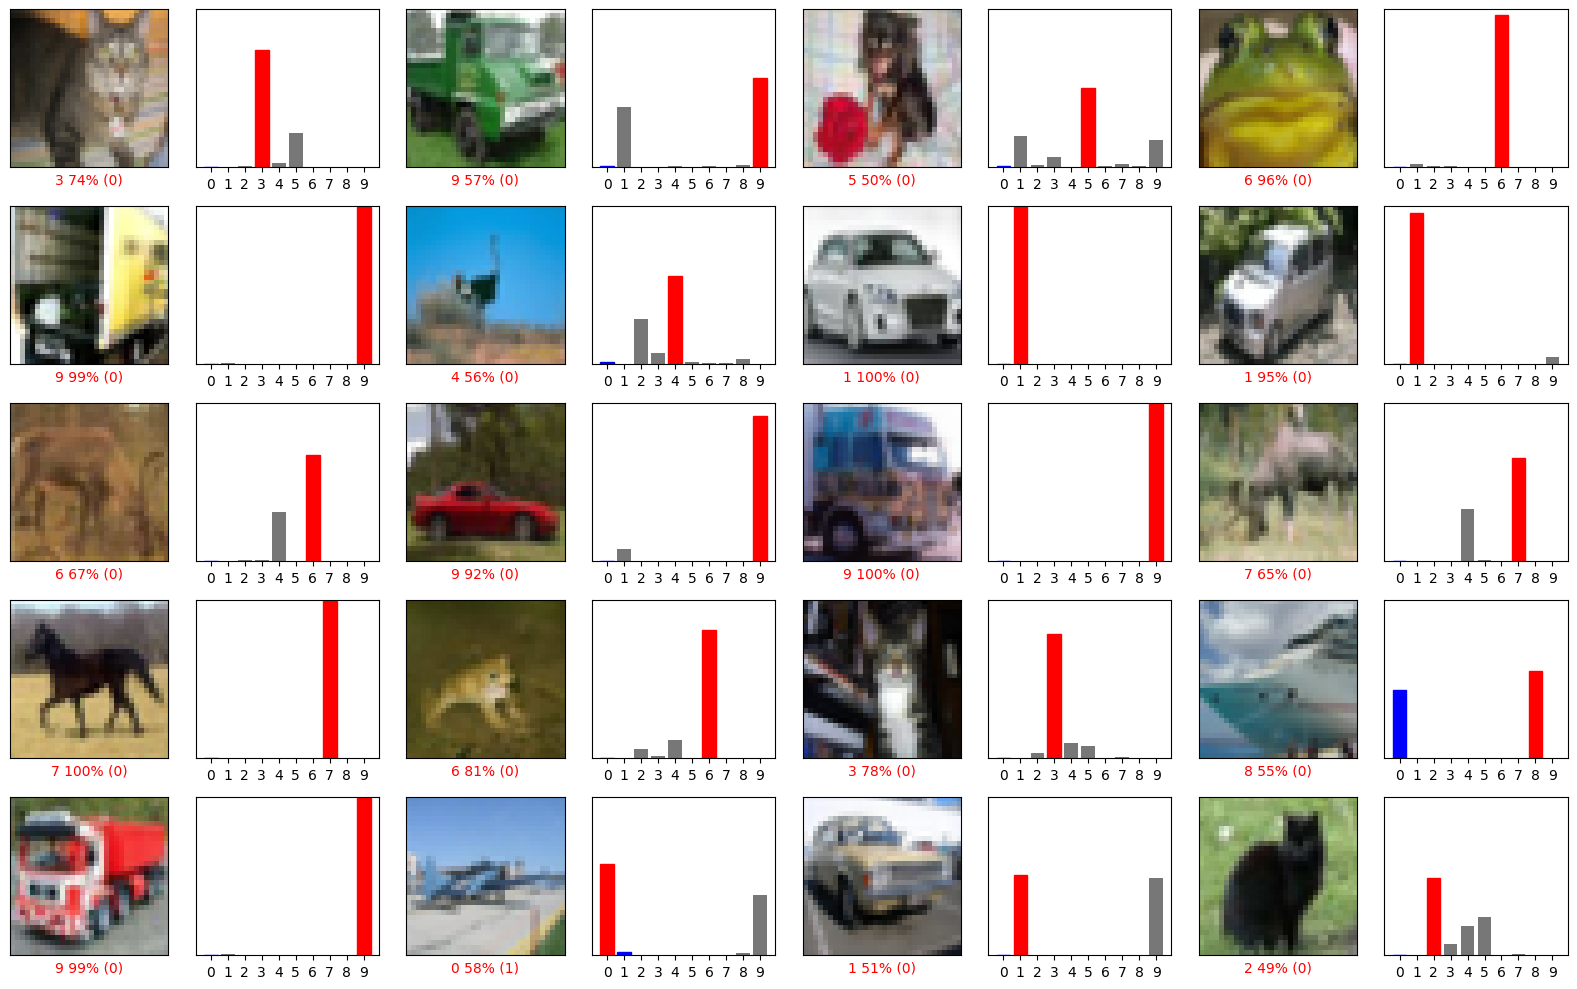

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, int(true_label[i][0]), img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                          100 * np.max(predictions_array),
                                          true_label),
                                          color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i][0])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i + start, predictions[i + start], y_test, x_test)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i + start, predictions[i + start], y_test)
plt.tight_layout()
plt.show()
